In [1]:
import warnings
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join
from IPython import display
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score # и другие метрики
from sklearn.cluster import KMeans # а также другие алгоритмы

/var/folders/2x/955c2pcd1cld0_8tfm105_pm0000gn/T/ipykernel_7603/592181555.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
DATA_PATH = "../data"
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Реализация Kmeans

5 баллов

В данном задании вам предстоит дописать код класса `MyKMeans`. Мы на простом примере увидим, как подбираются центры кластеров и научимся их визуализировать.

Сгенерируем простой набор данных, 400 объектов и 2 признака (чтобы все быстро работало и можно было легко нарисовать):

In [3]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])

Напишем функцию `visualize_clusters`, которая по данным и меткам кластеров будет рисовать их и разукрашивать:

In [4]:
def visualize_clusters(X, labels):
    """
    Функция для визуализации кластеров
        :param X: таблица объекты х признаки
        :param labels: np.array[n_samples] - номера кластеров
    """
    
    unique_labels = np.sort(np.unique(labels))
    sns.scatterplot(x = X[:, 0], y = X[:, 1], hue=labels, 
                    palette="colorblind", legend=False,
                    hue_order=unique_labels)
    plt.xlabel("$X_1$", fontsize=18)
    plt.ylabel("$X_2$", fontsize=18)
    
    for label in labels:
        center = X[(labels == label)].mean(axis=0)
        plt.scatter(center[0], center[1], s=80, c="#201F12", marker=(5, 2))

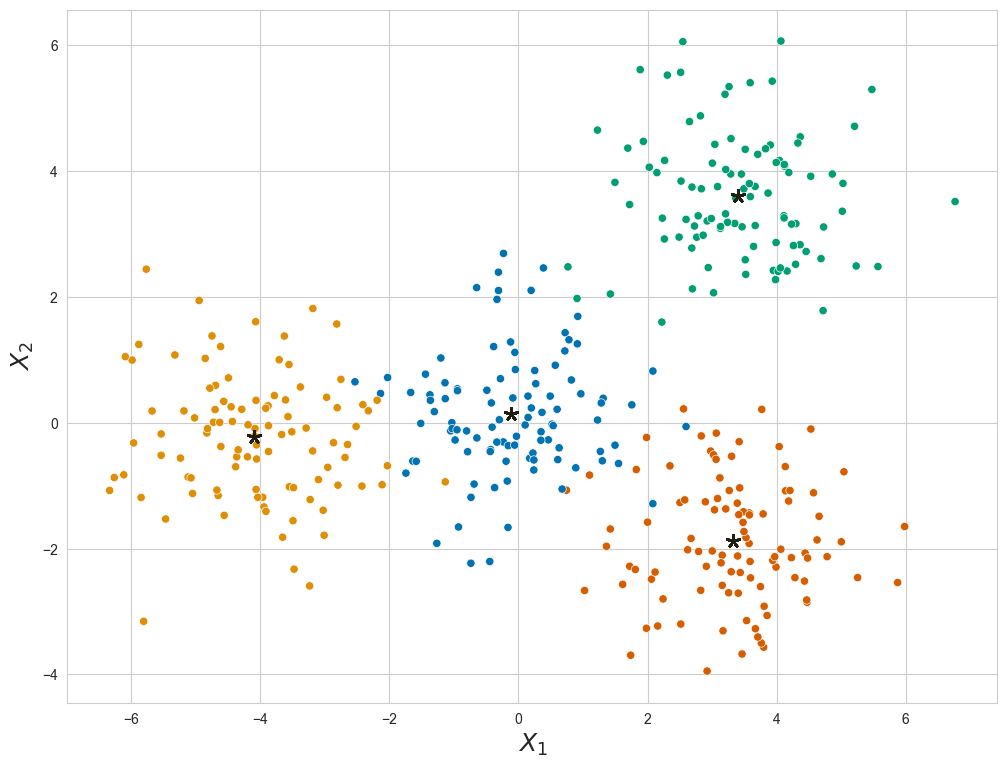

In [5]:
visualize_clusters(X, true_labels)

Напишем свой класс `MyKMeans`, который будет реализовывать алгоритм кластеризации K-средних. Напомним сам алгоритм:

1. Выбераем число кластеров (K)
2. Случайно инициализируем K точек (или выбираем из данных), это будут начальные центры наших кластеров
3. Далее для каждого объекта считаем расстояние до всех кластеров и присваиваем ему метку ближайщего
4. Далее для каждого кластера считаем "центр масс" (среднее значение для каждого признака по всем объектам кластера)
5. Этот "центр масс" становится новым центром кластера
6. Повторяем п.3, 4, 5 заданное число итераций или до сходимости

Во время предсказания алгоритм просто находит ближайщий центроид (центр кластера) для тестового объекта и возвращает его номер.

Реализуйте методы:
* `_calculate_distance(X, centroid)` - вычисляет Евклидово расстояние от всех объектов в `Х` до заданного центра кластера (`centroid`)
* `predict(X)` - для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент

In [6]:
class MyKMeans:
    def __init__(self, n_clusters, init="random", max_iter=300, visualize=False):
        """
        Конструктор класса MyKMeans
            :param n_clusters: число кластеров
            :param init: способ инициализации центров кластеров
                'random' - генерирует координаты случайно из нормального распределения
                'sample' - выбирает центроиды случайно из объектов выборки
            :param max_iter: заданное число итераций 
                (мы не будем реализовывать другой критерий остановки)
            :param visualize: рисовать ли кластеры и их центроиды в процессе работы
                код будет работать сильно дольше, но красиво...
        """
        
        assert init in ["random", "sample"], f"Неизвестный метод инициализации {init}"
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None
        self.visualize = visualize
       
    
    def fit(self, X):
        """
        Подбирает оптимальные центры кластеров
            :param X: наши данные (n_samples, n_features)
        :return self: все как в sklearn
        """
        
        n_samples, n_features = X.shape
        
        # Инициализация центров кластеров
        if self.init == "random":
            centroids = np.random.randn(self.n_clusters, n_features)
        elif self.init == "sample":
            centroids_idx = np.random.choice(np.arange(n_samples), 
                                             size=self.n_clusters, 
                                             replace=False)
            centroids = X[centroids_idx]
        
        # Итеративно двигаем центры
        for _ in range(self.max_iter):
            # Посчитаем расстояния для всех объектов до каждого центроида
            dists = []
            for centroid in centroids:
                dists.append(self._calculate_distance(X, centroid))
            dists = np.concatenate(np.array(dists), axis=1)
            # Для каждого объекта найдем, к какому центроиду он ближе
            cluster_labels = np.argmin(dists, axis=1)
            
            # Пересчитаем центр масс для каждого кластера
            centroids = []
            for label in np.sort(np.unique(cluster_labels)):
                center = X[(cluster_labels == label)].mean(axis=0)
                centroids.append(center)
            
            # Отрисуем точки, покрасим по меткам кластера, а также изобразим центроиды
            if self.visualize:
                visualize_clusters(X, cluster_labels)
                display.clear_output(wait=True)
                display.display(plt.gcf())
                plt.close()
                
        self.centroids = np.array(centroids)
        
        return self
    
    
    def predict(self, X):
        """
        Для каждого X возвращает номер кластера, к которому он относится
            :param X: наши данные (n_samples, n_features)
        :return cluster_labels: метки кластеров
        """

        dists = np.sqrt(np.sum((X[:, None, :] - self.centroids[None, :, :])**2, axis=2))
        
        cluster_labels = np.argmin(dists, axis=1)
            
        return cluster_labels
        
        
    def _calculate_distance(self, X, centroid):
        """
        Вычисляет Евклидово расстояние от всех объектов в Х до заданного центра кластера (centroid)
            :param X: наши данные (n_samples, n_features)
            :param centroid: координаты центра кластера
        :return dist: расстояния от всех X до центра кластера
        """
        
        dist = np.sqrt(np.sum((X - centroid)**2, axis=1)).reshape(X.shape[0], 1)
        
        return dist
    
    
    def __repr__(self):
        return f"Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*"

Обучите `MyKMeans` на наших игручешных данных, добейтесь сходимости. Не забудьте поставить `visualize=True`, чтобы посмотреть на красивые картинки. Также попробуйте различные способы инициализации центроидов и скажите, какой лучше подошел в этой ситуации.

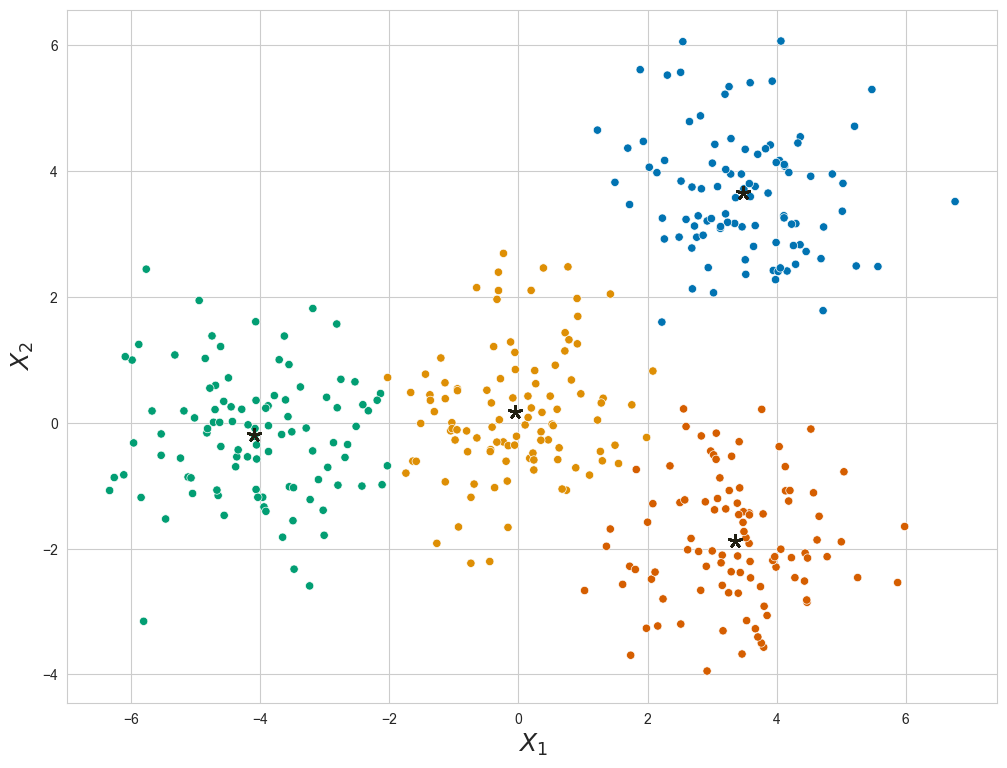

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [7]:
model = MyKMeans(n_clusters = 4, init="random", max_iter=20, visualize=True)
model.fit(X)

Actually, random and sample initialization of centroids works more or less equally here, but sometimes random ititialization positions centorids near each other and higher number of iterations is needed to properly identify clusters. I have used number of cycles around 10-20 to not overuse the computers capacity.

### Задание 2. Подбираем лучшую иерархическую кластеризацию

5 баллов

На лекции были рассмотрены различные расстояния, которые могут служить метриками различия между объектами. Также мы разобрали несколько алгоритмов кластеризации, в том числе и иерархическую. Часто может быть непонятно, какой алгоритм и какую метрику расстояния нужно взять. Давайте упростим себе жизнь и напишем функцию `algorithm_selection`, которая будет на основании переданных ей:

* метрик расстояния (можно брать все, что было на лекциях, минимум 4)
* параметра `linkage` ('average', 'single', 'complete')
* и метрик качества кластеризации ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')

будет выводить итоговую таблицу, в которую войдут столбцы:
* distance (метрика расстояния)
* linkage (алгоритм иерархической кластеризации)
* homogenity
* completeness
* v_measure
* silhouette

В результате по этой таблице, нужно сделать вывод о том, какой алгоритм кластеризации и с какими гиперпараметрами лучше всего сработал.

Загрузим наши данные:

In [8]:
data = load_digits()
X, y = data.data, data.target

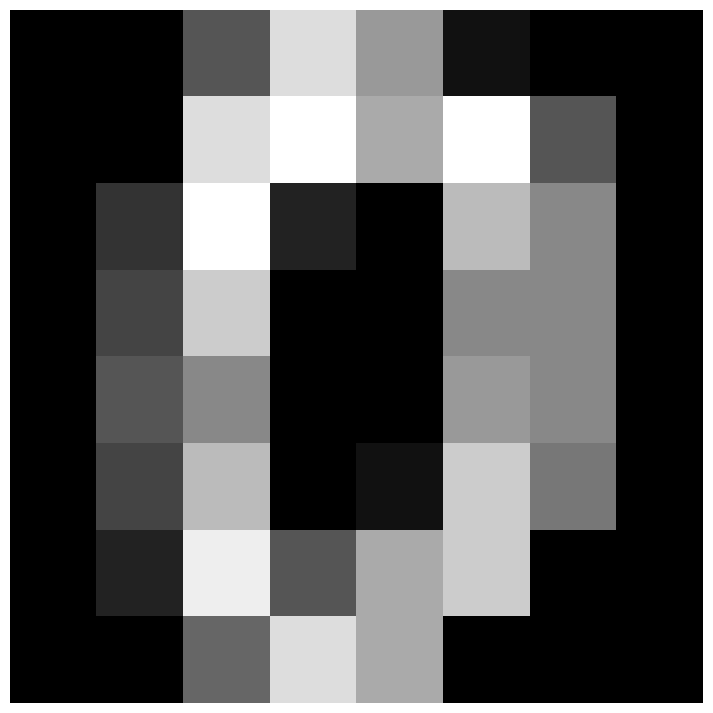

In [9]:
plt.imshow(X[0].reshape(8, 8).astype(int), cmap="gray")
plt.axis("off");

Работать будем с изображениями рукописных цифр. Тут все похоже на данные для 1 домашнего задания, каждая картинка представлена вектором из 64 элементов (числа от 0 до 255). Чтобы ее нарисовать мы должны сделать `reshape` в картинку 8 на 8 пикселей. Вам нужно будет выбрать наилучший способ кластеризации при помощи функции `algorithm_selection`, которую вы реализуете. Для некоторых метрик кластеризации требуются метки **классов** объектов (они хранятся в переменной `y`).

In [10]:
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [11]:
X.shape

(1797, 64)

##### YOUR TURN TO CODE

In [12]:
from sklearn.metrics import homogeneity_score
from sklearn.metrics import v_measure_score
from sklearn.metrics import completeness_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import HDBSCAN

In [13]:
def algorithm_selection(X, methods, distances, algorithms, metrics=None):
    """
    Для заданных алгоримов кластеризации и гиперпараметров 
    считает различные метрики кластеризации
        :param X: наши данные (n_samples, n_features)
        :param distances: список возможных метрик расстояния
        :param algorithm: параметр linkage ('average', 'single', 'complete')
        :param metrics: список возможных метрик качества кластеризации
    :return compare_dataframe: таблица с метриками кластеризации
    """

    #compare_dataframe = {'linkage': [], 'distance': [], 'silhouette': [], 'completeness':[], 'v_measure':[], 'homogeneity':[]}
    compare_dataframe = []
    
    for method in methods:
        for linkage in algorithms:
            if linkage == 'ward':
                distance = 'euclidean'
                if method == HDBSCAN:
                    model = HDBSCAN(metric = distance)
                    method_name = 'HDBSCAN'
                    linkage = '-'
                elif method == AgglomerativeClustering:
                    model = AgglomerativeClustering(n_clusters = 10, metric = distance, linkage = linkage)
                    method_name = 'AgglomerativeClustering'
                else:
                    raise ValueError('No such method available. Use HDBSCAN or AgglomerativeClustering')
                silhouette = silhouette_score(X, model.fit_predict(X), metric = distance)
                completeness = completeness_score(y, model.fit_predict(X))
                v_measure = v_measure_score(y, model.fit_predict(X))
                homogeneity = homogeneity_score(y, model.fit_predict(X))
                compare_dataframe.append(
                    {'method': method_name, 'linkage': linkage, 'distance': distance, 'silhouette': silhouette, 'completeness': completeness, 'v_measure': v_measure, 'homogeneity': homogeneity})
                #print(linkage, distance, silhouette, completeness, v_measure, homogeneity)
        
            else:
                for distance in distances:
                    if method == HDBSCAN:
                        model = HDBSCAN(metric = distance)
                        method_name = 'HDBSCAN'
                        linkage = '-'
                    elif method == AgglomerativeClustering:
                        model = AgglomerativeClustering(n_clusters = 10, metric = distance, linkage = linkage)
                        method_name = 'AgglomerativeClustering'
                    else:
                        raise ValueError('No such method available. Use HDBSCAN or AgglomerativeClustering')
                    silhouette = silhouette_score(X, model.fit_predict(X), metric = distance)
                    completeness = completeness_score(y, model.fit_predict(X))
                    v_measure = v_measure_score(y, model.fit_predict(X))
                    homogeneity = homogeneity_score(y, model.fit_predict(X))
                    compare_dataframe.append(
                        {'method': method_name, 'linkage': linkage, 'distance': distance, 'silhouette': silhouette, 'completeness': completeness, 'v_measure': v_measure, 'homogeneity': homogeneity})

    return pd.DataFrame(compare_dataframe)

In [14]:
Clustering_results = algorithm_selection(X, methods = [HDBSCAN, AgglomerativeClustering], distances = ['euclidean', 'manhattan', 'l1', 'l2', 'chebyshev'], algorithms=['average', 'single', 'complete', 'ward'])

In [15]:
Clustering_results['Total_average'] = (Clustering_results['silhouette']+Clustering_results['completeness']+Clustering_results['v_measure']+Clustering_results['homogeneity'])/4

In [16]:
Clustering_results.sort_values(by=['Total_average'], ascending=False).head(10)

method  linkage   distance  silhouette  completeness  \
31  AgglomerativeClustering     ward  euclidean    0.178497      0.879096   
20  AgglomerativeClustering  average  chebyshev    0.106666      0.828645   
19  AgglomerativeClustering  average         l2    0.146625      0.782342   
16  AgglomerativeClustering  average  euclidean    0.146625      0.782342   
0                   HDBSCAN        -  euclidean    0.071945      0.713843   
15                  HDBSCAN        -  euclidean    0.071945      0.713843   
8                   HDBSCAN        -         l2    0.071945      0.713843   
3                   HDBSCAN        -         l2    0.071945      0.713843   
10                  HDBSCAN        -  euclidean    0.071945      0.713843   
5                   HDBSCAN        -  euclidean    0.071945      0.713843   

    v_measure  homogeneity  Total_average  
31   0.868170     0.857513       0.695819  
20   0.797959     0.769464       0.625684  
19   0.713263     0.655393       0.574406  
16   0.713263     0.655393       0.574406  
0    0.735122     0.757709       0.569654  
15   0.735122     0.757709       0.569654  
8    0.735122     0.757709       0.569654  
3    0.735122     0.757709       0.569654  
10   0.735122     0.757709       0.569654  
5    0.735122     0.757709       0.569654

Actually, during this task I've been trying to create a function which would be able to combine different metrics. There are a lot of custom metrics for DBSCAN, but here I used default ones for both clustering techniques. DBSCAN performed more or less well according to the external metrics, which are around 0.65-0.75. Agglomerative clustering, as it was mentioned during the lecture also, performs very bed on single linkage, while **ward** shows the best performance. It is clear that it is better to use more precise linkage strategies which include data from all points in the cluster rather than use single, which calculates the distance just between 2 closest observations of 2 clusters.

Here I provide results that I have calculated using simple euristic like average of four metrics, as they all have more or less the same range of values([-1;1] for *silhouette* and [0;1] for *completeness*, *homogeneity* and *v_measure*.

### Задание 3. Аннотация клеточных типов

суммарно 10 баллов

В этом задании вам предстоит применять полученные знания о кластеризации для аннотации данных, полученных при помощи проточной цитометрии. Каждая строка в данных это одна клетка, столбцы **FSC-A**, **SSC-A** косвенным образом свидетельствуют о размере клеток, остальные показывают интенсивность флуоресценции различных поверхностных маркеров. Ваша задача определить для каждой клетки, к какому типу она относится.

#### 3.1. EDA

1.5 балла

Проведите EDA:

1. Посмотрите на данные (можно попробовать метод `describe`)
2. Сколько у нас клеток / признаков
3. Постройте распределения каждого признака (есть ли очевидные выбросы?)

In [17]:
fc_data = pd.read_csv(join(DATA_PATH, "flow_c_data.csv"), index_col=0)

##### YOUR TURN TO CODE:

In [18]:
fc_data.columns

Index(['FSC-A', 'SSC-A', 'HLA-DR', 'CD3', 'CD45', 'CD14', 'CD56', 'CD19',
       'CD11c'],
      dtype='object')

Here we observe different surface protein markers of immune cells. CD - cluster of differentiation. Using such panels we may distinguish different immune cell types.

In [19]:
fc_data.describe()

FSC-A         SSC-A        HLA-DR           CD3          CD45  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.962458      0.165415      1.791579      3.280391      5.169845   
std        0.500012      0.190773      2.027281      2.112079      0.518247   
min        0.144786      0.021657     -7.634172     -2.517639     -8.329666   
25%        0.798804      0.105550      0.275056      1.401943      4.922227   
50%        0.908574      0.130543      1.194313      4.373660      5.234119   
75%        1.052034      0.162536      3.696976      4.842212      5.481218   
max       42.954485     15.460997     12.946668     13.844391     13.710922   

               CD14          CD56          CD19         CD11c  
count  10000.000000  10000.000000  10000.000000  10000.000000  
mean       1.097182      0.412223      1.219683      0.569898  
std        1.375876      1.176967      2.285305      1.502445  
min       -8.833883    -12.358701     -9.640775    -11.085437  
25%        0.389746     -0.195978     -0.146948     -0.498781  
50%        0.672853      0.053267      0.244121      0.272297  
75%        1.065076      0.378576      0.908374      1.220576  
max        6.294236      6.461899      7.208721      6.840864

In [20]:
f'We have {fc_data.shape[0]} cells and {fc_data.shape[1]} features/surface markers'

'We have 10000 cells and 9 features/surface markers'

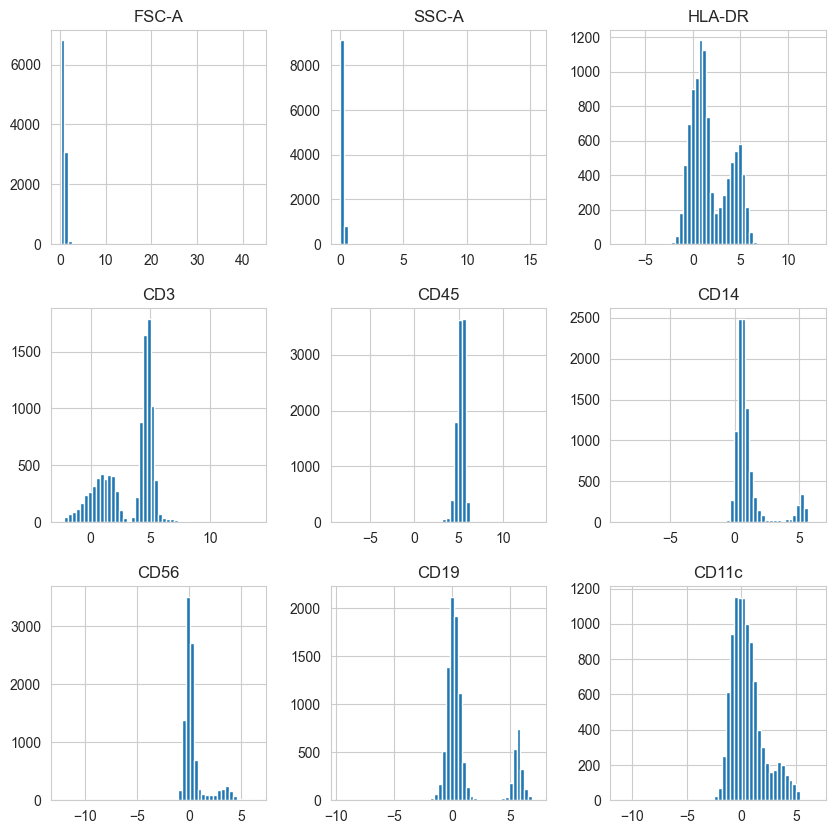

In [21]:
fc_data.hist(bins=50, figsize=(10,10))
plt.show()

More or less, data look very good. Peaks on flow cytometry histograms represent cell populations. But looking at the describe table it is easy to observe at least one outlier with values lying far away from average values of cells. Let's look more precisely on outliers.

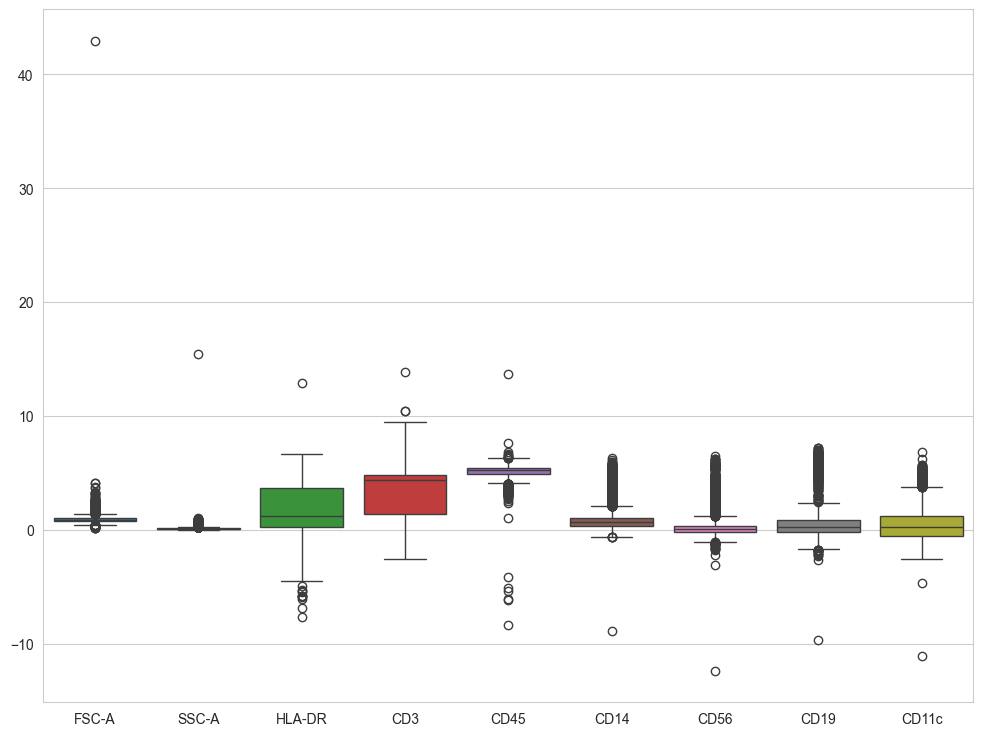

In [22]:
sns.boxplot(fc_data);

On the boxplots we clearly can see outliers. Again, outliers deletion is not a panacea. Many of outliers may actually carry some important biological information. Here I will delete only those observations which are:
1) Very distant from main points density
2) Are not surrounded by other dots (observations) from the same group, because in this case they may represent small population of cells.

I have been working with flow_cytometry a lot and negative values are usually are observed due to cytometer settings or mathematical tranformation of the data. Biologically, cell can't have negative level of surface marker expression.

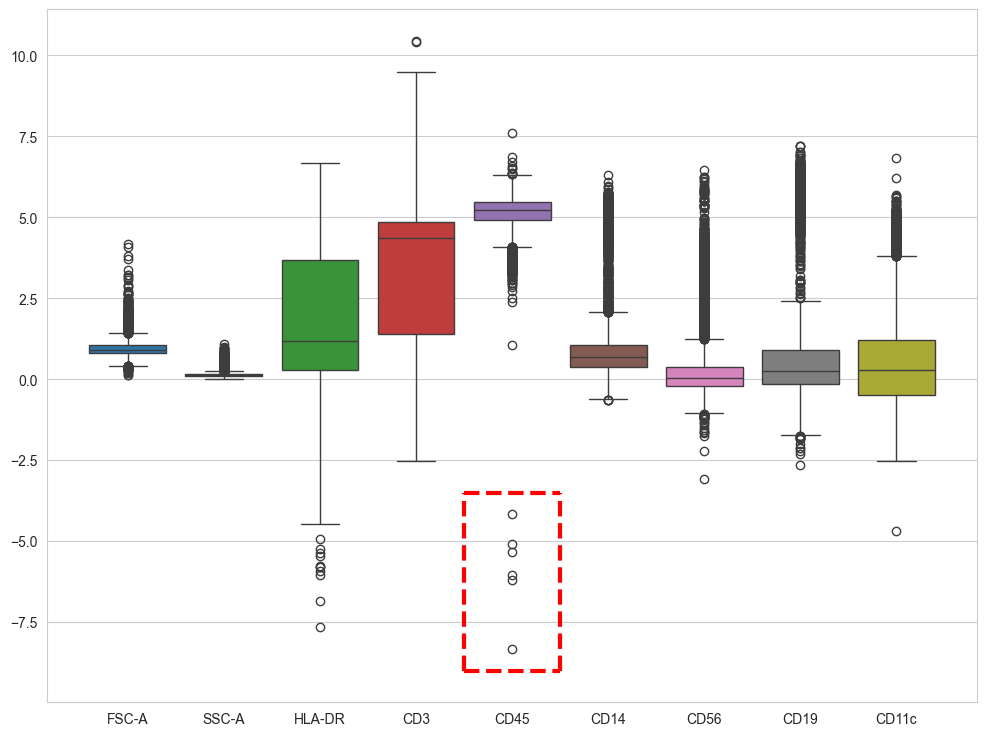

In [23]:
fc_data_filt = fc_data[(fc_data['FSC-A'] < 40) & (fc_data['CD56'] > -10)]
sns.boxplot(fc_data_filt)
plt.hlines(y = -3.5, xmin = 3.5, xmax =4.5, linestyle = '--', color = 'red', linewidth=3)
plt.hlines(y = -9, xmin = 3.5, xmax =4.5, linestyle = '--', color = 'red', linewidth=3)
plt.vlines(x = 3.5, ymin = -9, ymax =-3.5, linestyle = '--', color = 'red', linewidth=3)
plt.vlines(x = 4.5, ymin = -9, ymax =-3.5, linestyle = '--', color = 'red', linewidth=3);

In [24]:
# Perform scaling of the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(fc_data_filt)
fc_data_filt_scaled_numpy = scaler.transform(fc_data_filt)
fc_data_filt_scaled = pd.DataFrame(fc_data_filt_scaled_numpy, index=fc_data_filt.index, columns=fc_data_filt.columns)
fc_data_filt_scaled

FSC-A     SSC-A    HLA-DR       CD3      CD45      CD14      CD56  \
0    -0.869868 -0.084679 -0.640257 -1.311480 -2.174791 -0.057510  3.071559   
1    -0.763466 -0.432197  1.423500 -1.164906 -0.461386 -0.684105 -0.538375   
2     0.552481 -0.121709 -1.093425  0.344651  0.875253 -0.421889  0.315873   
3    -1.492213 -0.385607 -0.713610  0.025113  0.179874  0.279136 -0.127053   
4    -0.675726 -0.762337  1.578147 -1.134823 -1.186762 -0.642037 -0.279672   
...        ...       ...       ...       ...       ...       ...       ...   
9995  0.819913  2.434893  0.319572 -0.831147 -1.396587  2.756217 -0.056427   
9996 -0.700067 -0.456366 -0.483264  0.462286 -0.314097  0.149448 -0.464733   
9997  1.314442  0.611438  1.162759 -0.932661  0.335067  0.364720 -0.599012   
9998 -0.236293 -0.233214 -0.996265 -1.437604 -1.445303 -0.466590  1.701502   
9999 -0.483899  0.198581 -1.004830 -1.267178 -1.373392 -0.723966  2.841636   

          CD19     CD11c  
0    -1.151117 -0.124612  
1     2.108919  0.003989  
2    -0.674387 -0.710918  
3    -0.230377  1.899903  
4     1.902367 -0.066408  
...        ...       ...  
9995 -0.793838  1.526569  
9996 -0.384015 -0.799684  
9997 -0.923392  2.535676  
9998 -0.584288 -0.335016  
9999 -0.728176 -0.128667  

[9999 rows x 9 columns]

I have visualized with dashed box a group of cells which look like outliers, but there are several of them together, which may have some biologically relevant information. Actually, we would be able to delete them later.



#### 3.2. Кластеризация

4.5 балла

При ручной аннотации клеточных типов обычно поступают следующим образом:

1. При помощи методов понижения размерности рисуют наши наблюдения, чтобы примерно оценить число клеточных типов
2. Проводят кластеризацию наблюдений (для некоторых методов нужно заранее задать число кластеров, поэтому нам как раз помогает п.1)
3. Далее мы считаем, что клетки, которые алгоритм отнес к одному кластеру являются одним клеточным типом (если кластеров больше, чем типов клеток, то возможно, что 2 разных кластера являются одним типом)
4. После чего по интенсивности экспрессии поверхностных маркеров мы присваиваем кластеру клеточный тип

Давайте для начала напишем удобную функцию для визуализации наших многомерных данных в пространстве размерностью 2, делать мы это будем при помощи алгоритма t-SNE.

Поиграться с красивой визуализацией можно [тут](https://distill.pub/2016/misread-tsne/).

In [25]:
def plot_tsne(data, n_iter=1000, 
              perplexity=40, color=None):
    """
    Функция для отрисовки результатов работы t-SNE
        :param data: таблица объекты х признаки
        :param n_iter: число итераций градиентного спуска,
            может быть полезно увеличить, чтобы получить результаты получше
        :param perplexity: 
        :param color: np.array[n_samples] с переменной,
            которой мы хотим покрасить наши наблюдения
        :return tsne_emb: np.array[n_samples, 2] - результаты работы t-SNE
    """
    
    # Сначала сделаем PCA, так как это хорошее начальное приближение для t-SNE
    # позволит алгоритму быстрее сойтись
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)
    
    # Запустим t-SNE, он выдаст нам для каждого объекта по 2 числа, 
    # которые мы сможем нарисовать
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity)
    tsne_embedding = tnse.fit_transform(pca_embedding)
    
    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette="colorblind")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)
    
    # Вернем также результаты t-SNE, так как, если потом захотим перестроить картинку,
    # в таком случае нам не придется ждать заново, просто нарисуем новую с готовыми данными
    
    return tsne_embedding

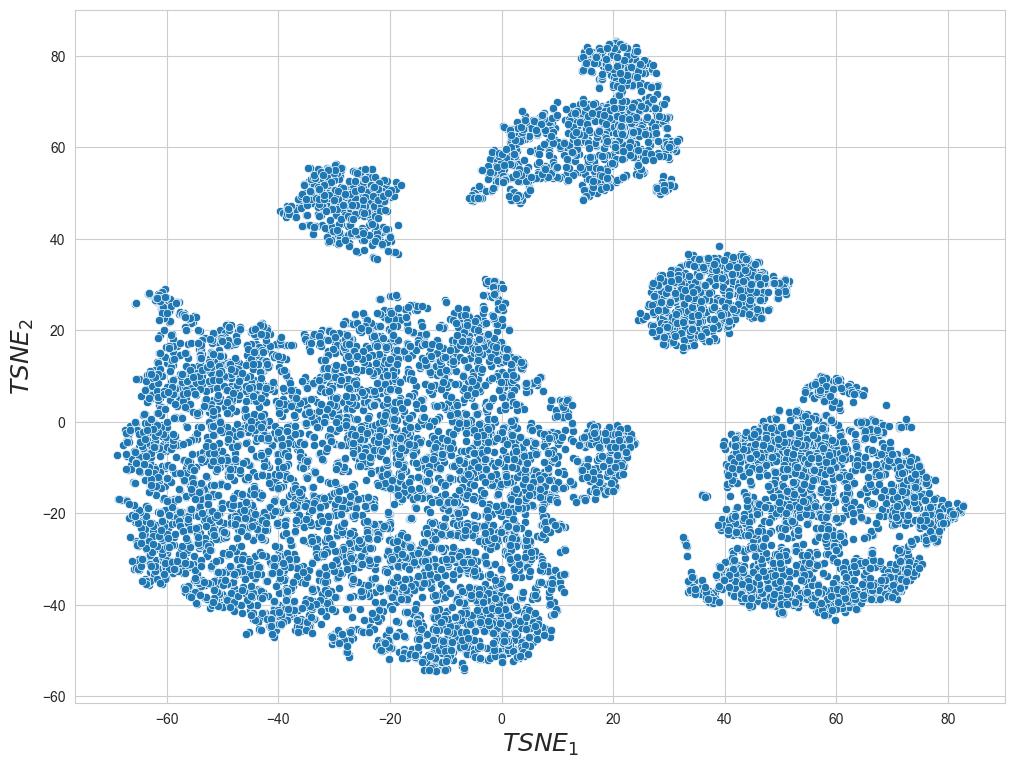

In [26]:
tsne_res = plot_tsne(fc_data_filt)

Кластеризуйте ваши данные:

1. Попробуйте методы кластеризации из тех, что мы прошли
2. Выберите лучший на основании метрики `silhouette_score` (попробуйте также подобрать гиперпараметры)
3. Присвойте каждому наблюдению метку класса и нарисуйте график t-SNE, покрасив точки метками кластера

In [27]:
def algorithm_selection_internal(X, methods, distances, algorithms, n_clust, epsilons, metrics=None):
    """
    Для заданных алгоримов кластеризации и гиперпараметров 
    считает различные метрики кластеризации
        :param X: наши данные (n_samples, n_features)
        :param distances: список возможных метрик расстояния
        :param algorithm: параметр linkage ('average', 'single', 'complete')
        :param metrics: список возможных метрик качества кластеризации
    :return compare_dataframe: таблица с метриками кластеризации
    """

    #compare_dataframe = {'linkage': [], 'distance': [], 'silhouette': [], 'completeness':[], 'v_measure':[], 'homogeneity':[]}
    compare_dataframe = []


    for method in methods:
        if method == HDBSCAN:
            for epsilon in epsilons:
                for distance in distances:
                    if distance == 'cosine':
                        continue
                    model = HDBSCAN(metric = distance, cluster_selection_epsilon = epsilon)
                    method_name = 'HDBSCAN'
                    linkage = '-'
                    clust = '-'
                    silhouette = silhouette_score(X, model.fit_predict(X), metric = distance)
                    compare_dataframe.append({'method': method_name, 'linkage': linkage, 'distance': distance, 'n_clust': clust, 'epsilon': epsilon, 'silhouette': silhouette}) 
        elif method == AgglomerativeClustering:
            for linkage in algorithms:
                if linkage == 'ward':
                    distance = 'euclidean'
                    for clust in n_clust:
                        model = AgglomerativeClustering(n_clusters = clust, metric = distance, linkage = linkage)
                        method_name = 'AgglomerativeClustering'
                        silhouette = silhouette_score(X, model.fit_predict(X), metric = distance)
                        compare_dataframe.append(
                            {'method': method_name, 'linkage': linkage, 'distance': distance, 'n_clust': clust, 'epsilon': '-', 'silhouette': silhouette})
                else:
                    for distance in distances:
                        for clust in n_clust:
                            model = AgglomerativeClustering(n_clusters = clust, metric = distance, linkage = linkage)
                            method_name = 'AgglomerativeClustering'
                            silhouette = silhouette_score(X, model.fit_predict(X), metric = distance)
                            compare_dataframe.append(
                                {'method': method_name, 'linkage': linkage, 'distance': distance, 'n_clust': clust, 'epsilon': '-', 'silhouette': silhouette})
        elif method == KMeans:
            for clust in n_clust:
                model = KMeans(n_clusters = clust)
                method_name = 'KMeans'
                linkage = '-'
                distance = '-' 
                silhouette = silhouette_score(X, model.fit_predict(X), metric = 'euclidean')
                compare_dataframe.append(
                    {'method': method_name, 'linkage': linkage, 'distance': distance, 'n_clust': clust, 'silhouette': silhouette}) 
        else:
            raise ValueError('No such method available. Use HDBSCAN, AgglomerativeClustering or KMeans')

    return pd.DataFrame(compare_dataframe)

Below you may find the code to search for the best parameters and methods for clusterization. It will run around 10 min depending on different factors.

In [28]:
Clustering_results_FC = algorithm_selection_internal(fc_data_filt, methods = [HDBSCAN, AgglomerativeClustering, KMeans], distances = ['euclidean', 'manhattan', 'l1', 'l2', 'chebyshev', 'cosine'], algorithms=['average', 'single', 'complete', 'ward'], n_clust = [4,5,6], epsilons = [0, 1, 3, 5, 7, 9])
Clustering_results_FC_scaled = algorithm_selection_internal(fc_data_filt_scaled, methods = [HDBSCAN, AgglomerativeClustering, KMeans], distances = ['euclidean', 'manhattan', 'l1', 'l2', 'chebyshev', 'cosine'], algorithms=['average', 'single', 'complete', 'ward'], n_clust = [4,5,6], epsilons = [0, 1, 3, 5, 7, 9])

In [47]:
Clustering_results_FC.sort_values(by=['silhouette'], ascending=False).head(5)

method   linkage distance n_clust epsilon  silhouette
46  AgglomerativeClustering   average   cosine       5       -    0.848101
82  AgglomerativeClustering  complete   cosine       5       -    0.838267
47  AgglomerativeClustering   average   cosine       6       -    0.813316
45  AgglomerativeClustering   average   cosine       4       -    0.776614
81  AgglomerativeClustering  complete   cosine       4       -    0.739807

In [30]:
Clustering_results_FC_scaled.sort_values(by=['silhouette'], ascending=False).head(5)

method linkage   distance n_clust epsilon  silhouette
24                  HDBSCAN       -  chebyshev       -       7    0.888327
19                  HDBSCAN       -  chebyshev       -       5    0.888327
29                  HDBSCAN       -  chebyshev       -       9    0.888327
14                  HDBSCAN       -  chebyshev       -       3    0.888327
60  AgglomerativeClustering  single  chebyshev       4       -    0.867492

According to silhouette score we can see that both AgglomerativeClustering and HDBSCAN performed well depending on scaled or non-scaled data. I will use 1 one in unscaled and first one in scaled table and look for which one the t-SNE would be better.

Удалось ли вам получить ситуацию, где отдельные группы точек покрашены в один цвет?

По итогу да, но не сразу

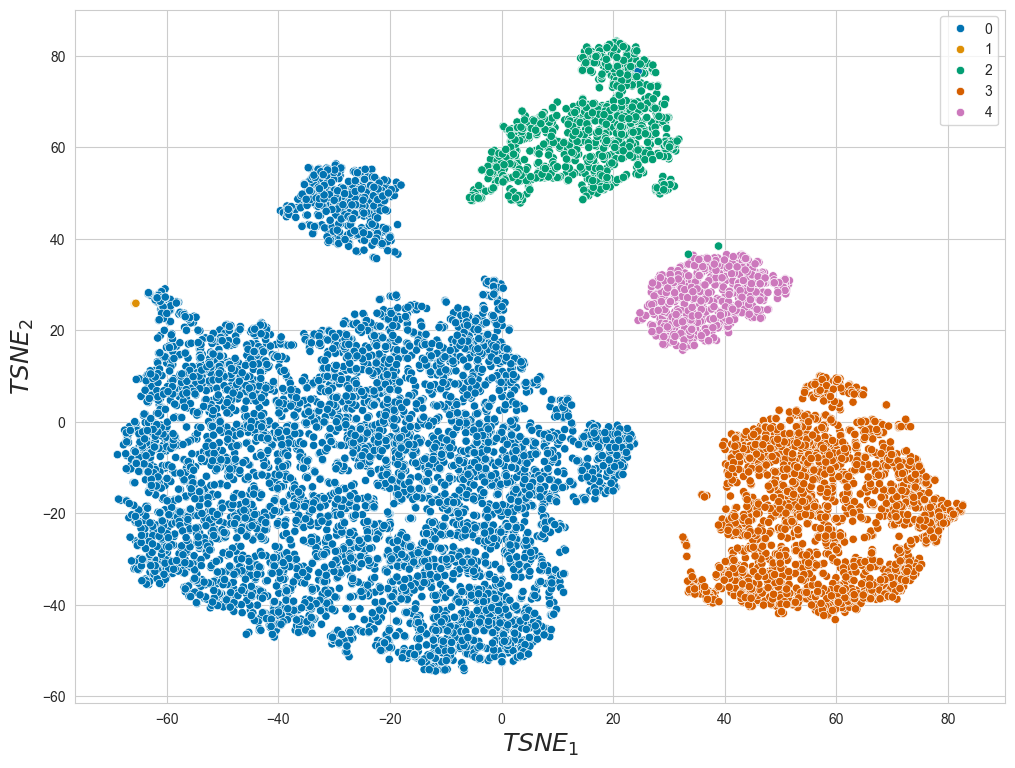

In [31]:
tsne_res_mapped = plot_tsne(fc_data_filt, color = AgglomerativeClustering(n_clusters = 5, linkage = 'average', metric = 'cosine').fit_predict(fc_data_filt))

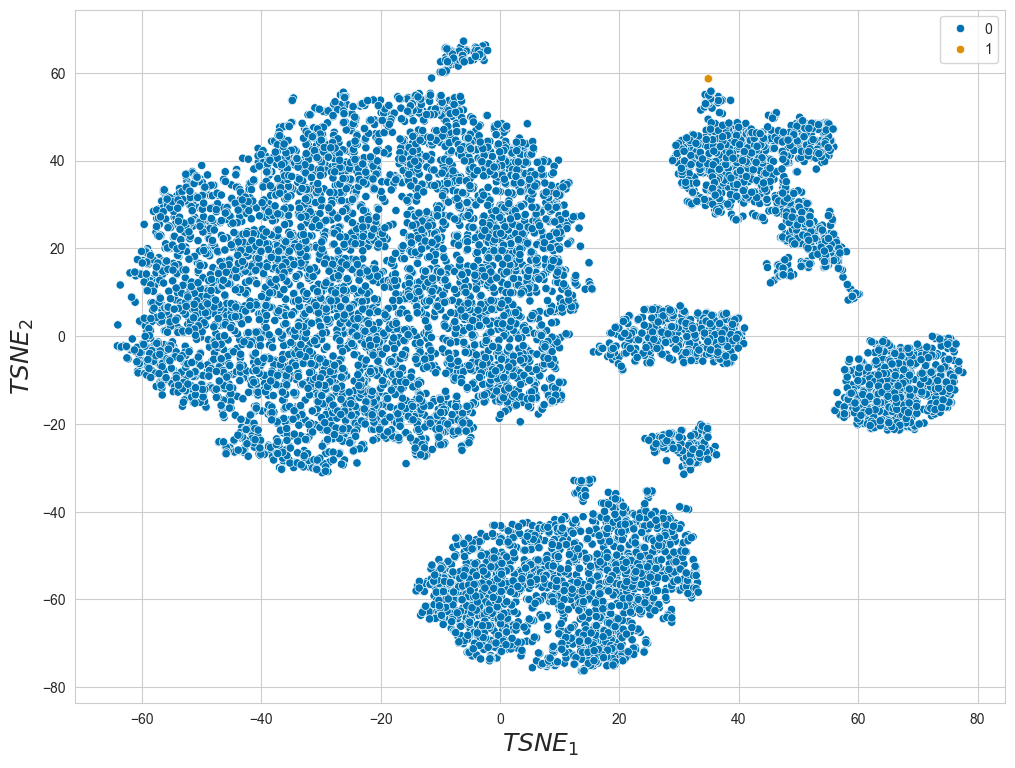

In [32]:
tsne_res_mapped_scaled = plot_tsne(fc_data_filt_scaled, color = HDBSCAN(cluster_selection_epsilon = 7, metric = 'chebyshev').fit_predict(fc_data_filt_scaled))

So far, I see that AgglomerativeClustering on unscaled data is the best performance. I have tried AgglomerativeClustering on scaled data, but results were worser, so I do not provide plots here. HDBSCAN didn't perform good clustering.

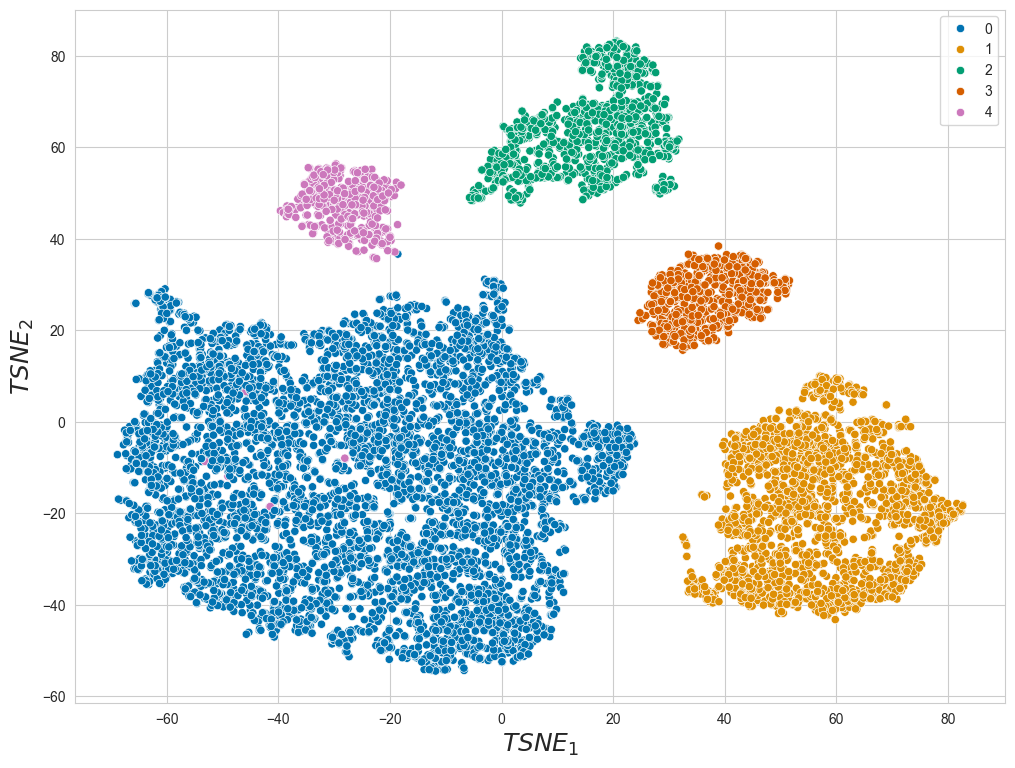

In [33]:
tsne_res_mapped = plot_tsne(fc_data_filt, color = AgglomerativeClustering(n_clusters = 5, linkage = 'ward', metric = 'euclidean').fit_predict(fc_data_filt))

According to information from lecture, the **ward** is mostly used, and with the **ward** we see the best performance of tSNE

#### 3.3. Аннотация клеточных типов

4 балла

Теперь когда мы подобрали хороший алгоритм кластеризации, можно аннотировать наши клетки. Для этого мы нарисуем t-SNE и покрасим точки в зависимости от интенсивности экспрессии поверхностных маркеров. В датасете присутствуют следующие типы клеток:

* B_cells
* T_cells
* Monocytes
* Other cells

Вам нужно будет выяснить, какие клетки экспрессируют определенные маркеры и присвоить каждому кластеру один из типов клеток.

To perform this task, I have analysed information of surface cell markers from:
1) https://www.abcam.com/primary-antibodies/immune-cell-markers-poster
2) https://www.cellsignal.com/pathways/immune-cell-markers-human

# Для начала нарисуем все это безобразие:

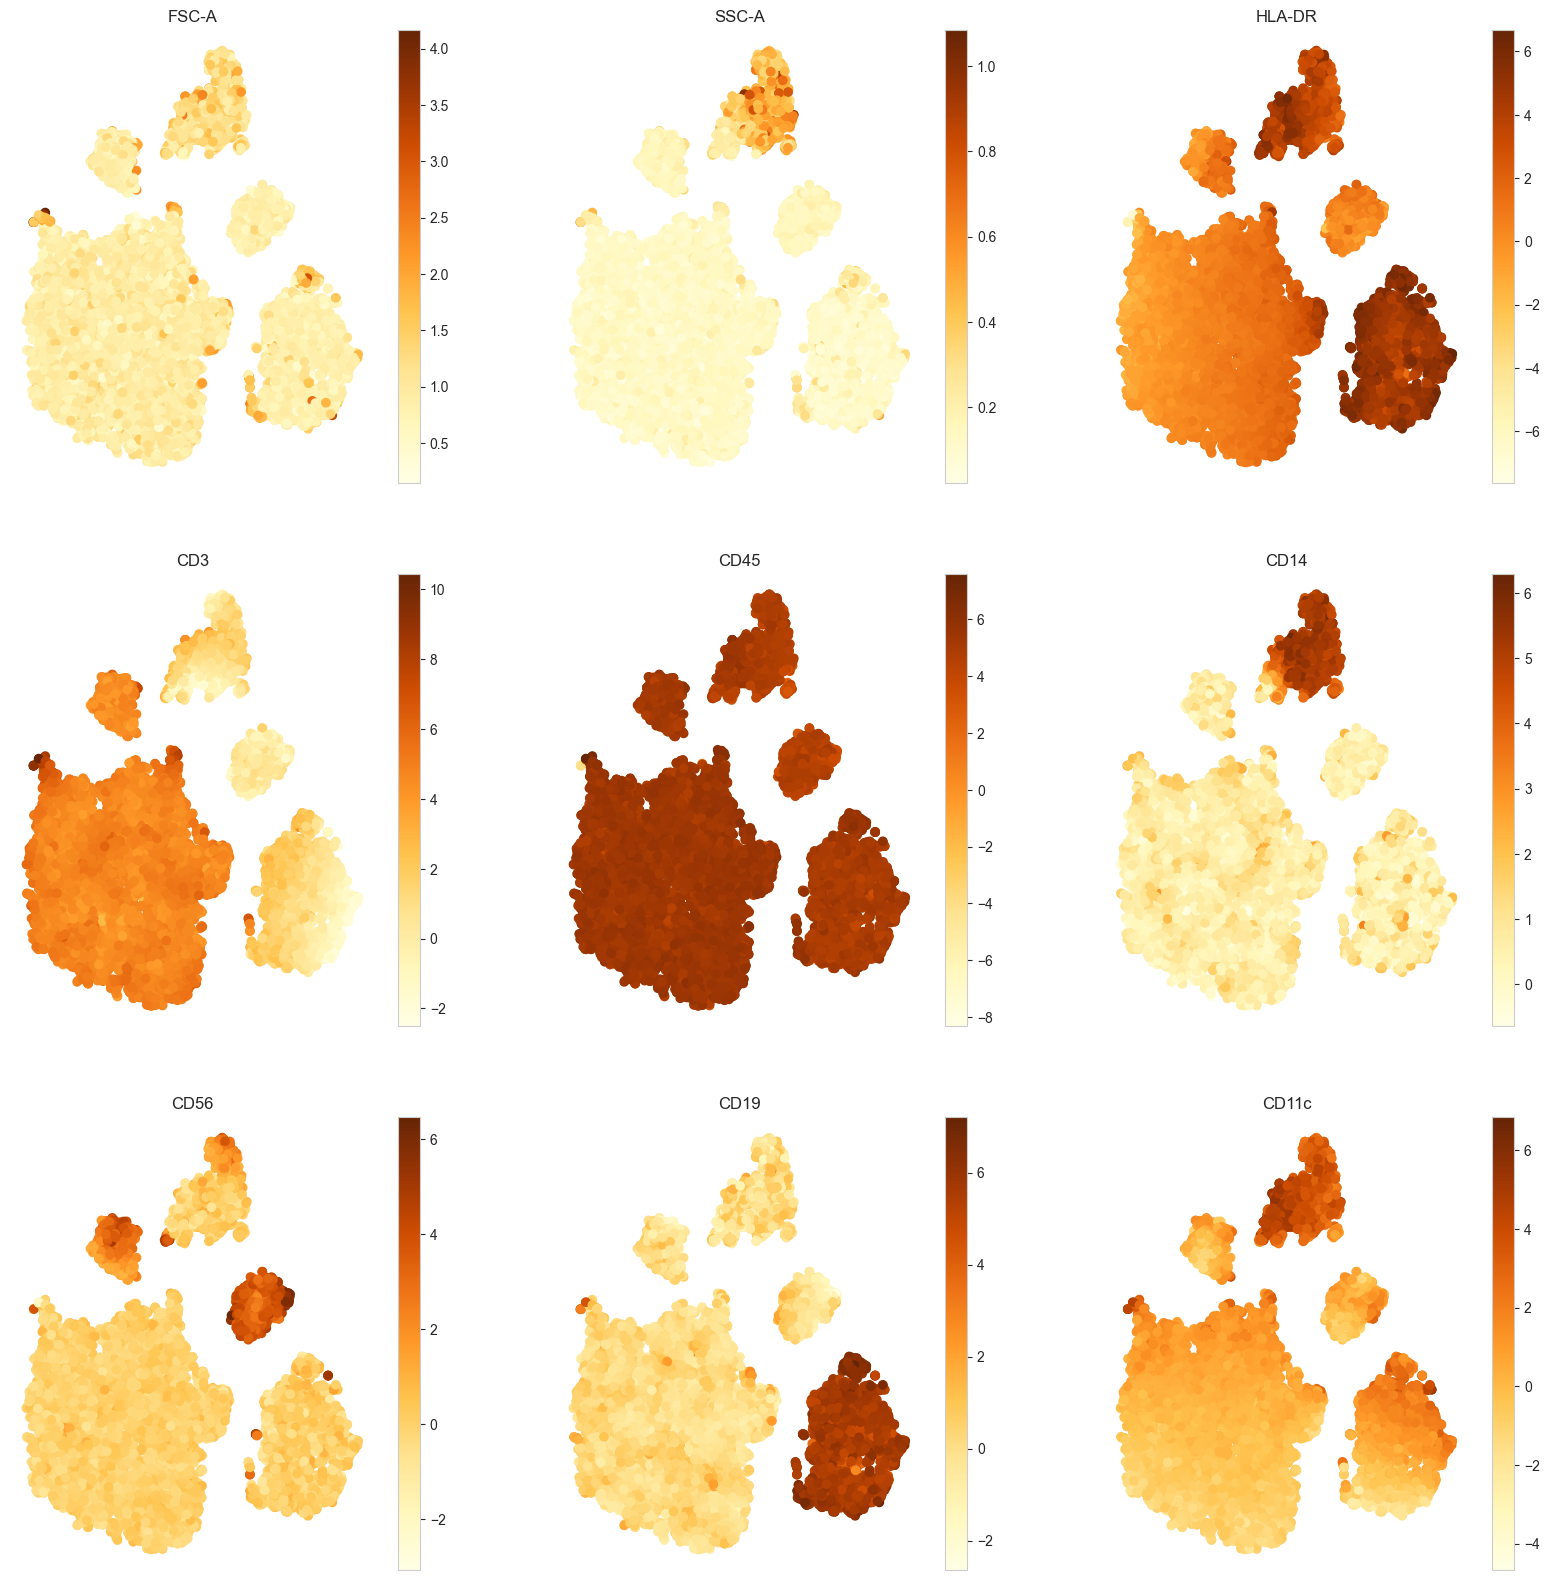

In [34]:
# Результаты t-SNE уже есть в переменной tsne_res
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for col, ax in zip(fc_data.columns, axes.ravel()):
    scatter = ax.scatter(tsne_res[:, 0], tsne_res[:, 1], 
                         c=fc_data_filt[col], cmap="YlOrBr")
    fig.colorbar(scatter, ax=ax)
    ax.set_title(col)
    ax.grid(False)
    ax.axis("off")

Actually, this is very interesting task. We can see that cluster 2 has high expression of HLA-DR, CD14 and CD11c, which indicates on monocytes and cDC. Also we can see that expression of CD11c is higher on the left side od the cluster, while CD14 - on the right part. I think that with more precise settings of perplexity and other parameters we would be able to separate these cell populations.

Also I see 2 distinct clusters on t-SNE, which are not separated by clustering methods. They are almost same in all markers except CD56. According to data, I may propose that these are NKT cells.

Дальше дело за вами, нужно определить клеточный тип для каждого кластера и записать их как значения в словаре:

In [35]:
cell_type_cluster_map = {0: "T cells", 
                         1: "B cells", 
                         2: "Monocytes and cDC", 
                         3: "NK cells",
                         4: "NKT cells"}

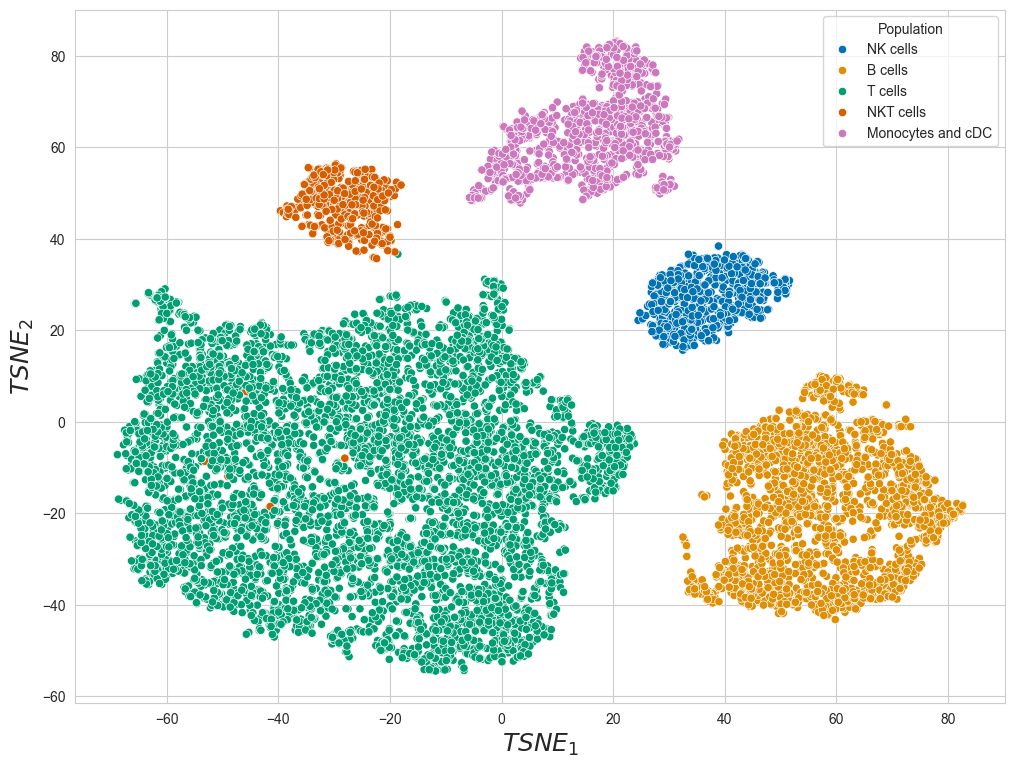

In [36]:
labeled_fc_data = fc_data_filt.assign(Population=AgglomerativeClustering(n_clusters = 5, linkage = 'ward', metric = 'euclidean').fit_predict(fc_data_filt))
labeled_fc_data["Population"] = labeled_fc_data["Population"].map(cell_type_cluster_map)

tsne_labeled_data = plot_tsne(labeled_fc_data.loc[:, labeled_fc_data.columns != 'Population'], color = labeled_fc_data["Population"]);

Посчитайте, как распределены типы клеток:

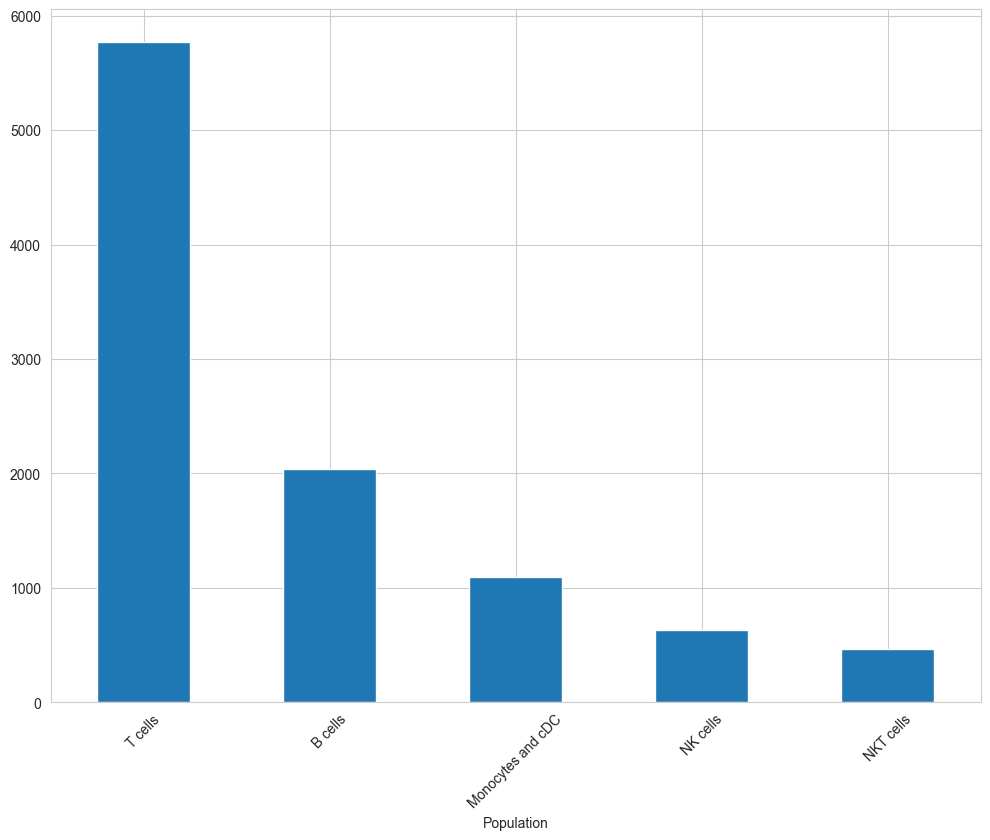

In [37]:
labeled_fc_data['Population'].value_counts().plot(kind = 'bar')
plt.xticks(rotation=45);

T cells are the most abundunt class. To be honest, the T cells diversity is incredible, and if we would have more markers, we could distinguish them between each other (single-cell transcriptomics). As for my knowldge, result are correlated with the immunological data.

Сохраните ваши результаты в csv файл, мы сравним их с правильными ответами по метрике `f1_score(average="macro")`, которая хорошо подходит, даже если классы не сбалансированы.

In [38]:
labeled_fc_data.to_csv('../data/labeled_fc_data.csv', index=True)

#### 3.4. Автоматическая аннотация

**дополнительные** 5 баллов

Это задание является дополнительным. Вам нужно построить классификатор клеточных типов на основе размеченных вами данных. Пока что мы прошли не так много разных классификаторов, но уже есть из чего выбирать.

Оцените качество полученной модели при помощи `f1_score(average="macro")`. Попробуйте его улучшить, каким-то образом поработав с дисбалансом классов([помощь](https://elitedatascience.com/imbalanced-classes)).

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [40]:
X = labeled_fc_data.loc[:, labeled_fc_data.columns != 'Population']
y = labeled_fc_data['Population']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.35,
                                                    random_state=SEED,
                                                    stratify=y)

In [41]:
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)
predictions = knn_classifier.predict(X_test)

In [43]:
def find_best_k_m(X_train, y_train, X_test, y_test, params):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    train_metrics = np.empty((len(params)))
    test_metrics = np.empty((len(params)))
    for i in range(len(params)):
        knn_classifier = KNeighborsClassifier(n_neighbors=params[i])
        knn_classifier.fit(X_train, y_train)
        test_prediction = knn_classifier.predict(X_test)
        train_prediction = knn_classifier.predict(X_train)
        test_metrics[i] = f1_score(y_test, test_prediction, average='macro')
        train_metrics[i] = f1_score(y_train, train_prediction, average='macro')
        
    return train_metrics, test_metrics

In [44]:
params = [1, 2, 4, 5, 8, 10, 30, 50, 100]
train_metrics, test_metrics = find_best_k_m(X_train, y_train, X_test, y_test, params)

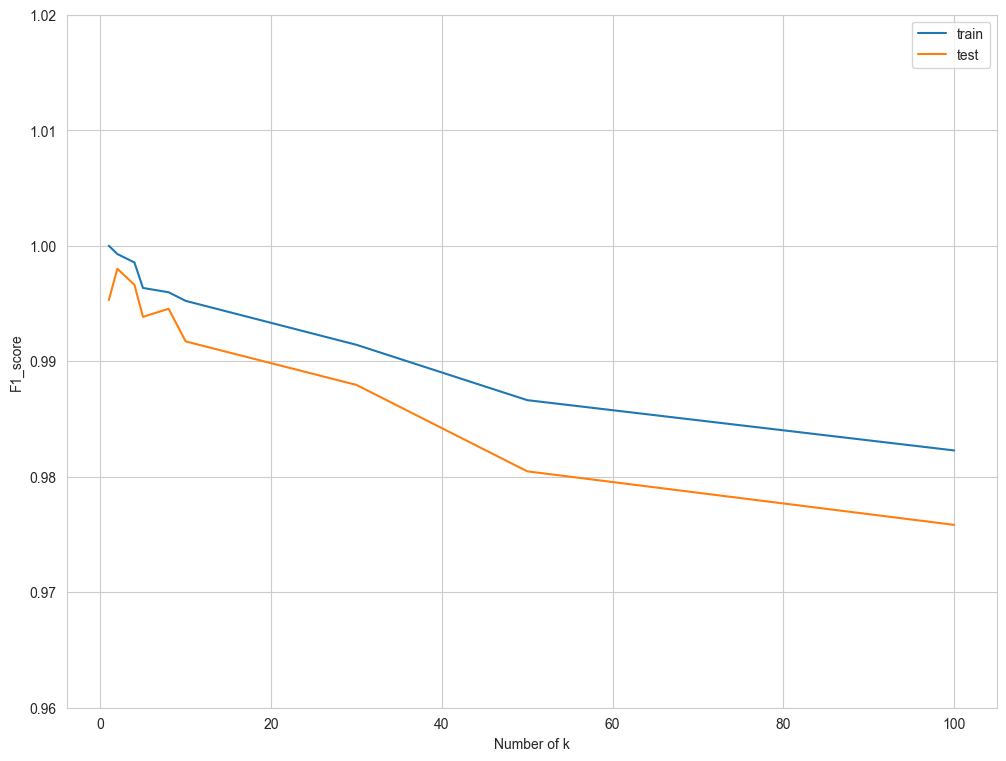

In [45]:
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.ylim(0.96, 1.02)
plt.xlabel("Number of k")
plt.ylabel("F1_score");

F1_score is pretty good along the whole range, but better performance is on k < 10.

### Задание 4. Любимое место

дополнительно 0.5 балла

Расскажите о вашем любимом месте, куда бы вы хотели съездить этой весной, если вы уже там бывали, то прикрепите фотографию)

Я люблю ходить в походы, поэтому весной бы я очень хотел оказаться в горах. В прошлом году я ходил сольный поход на Кавказе, а вот фоточка из похода по центральному Тавру, Турция.

![mountains](../img/mountains.jpg)

### Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

Мне крайне понравилась третья часть, потому что я долгое время работал с проточной цитометрией и это новый способ для меня вщглянуть на такие данные. Сходу было непонятно, что ожидается в задании 2, но в целом тоже интересно.

Также мне понравилось прогонять модели с разными параметрами и пытаться поискать что-то более менее хорошее. Все-таки, обучение без учителя вещь сама по себе лишенная абсолютной точности, поэтому подобный бенчмаркинг очень нужна процедура, на мой взгляд. 

Постарался учесть комментарии про плохие графики, улучшил немного представление данных, надеюсь в целом графики будут понятные. К сожалению, не хватило времени, чтобы сделать еще и очень красивыми :(